# Exploratory Data Analysis

## Import Data

I imported the tidy visa dataset from the previous notebook, and readjusted the numeric dtypes, which were not preserved on export.

In [1]:
import pandas as pd
import numpy as np

In [2]:
import altair as alt
from vega_datasets import data

In [3]:
visas = pd.read_csv('/data/markellekelly/visas.csv',parse_dates=['decision_date'],
                   dtype=str,index_col=0)

In [4]:
numeric_list = ['employer_num_employees','job_info_experience_num_months','overall_wage_offer','employer_desperation',
               'annual_wage']
for x in numeric_list:
    visas[x] = visas[x].apply(pd.to_numeric)

## Question 1: Which employers, cities, and industries are bringing in the most immigrants? What countries are they coming from?

### Top 75 Cities Requesting Permanent Visas and Respective Employers

Creates an interactive visualization of the 75 cities with the most permanent visa requests, showing their top employers and the number of visa requests from that specific employer.

In [5]:
cities = visas['case_no'].groupby(visas['job_info_work_city']).aggregate('count').reset_index()

In [6]:
cities.sort_values(by='case_no',ascending=False)
top75cities = cities.sort_values(by='case_no',ascending=False)[:75]

In [7]:
top75cities['latitude'] = [40.7128,30.6280,37.3382,47.6740,29.7604,
                           37.7749,37.3861,37.3541,37.3688,47.6062,
                           33.0198,41.8781,34.0522,32.7157,40.5187,
                           32.8140,33.7490,30.2672,32.7791,37.5483,
                           45.5229,37.3230,37.4419,40.7282,42.3601,
                           42.7284,25.7617,33.6846,42.4990,39.9612,
                           40.5549,34.0754,37.4530,38.9072,27.9506,
                           47.6101,38.9696,40.5754,38.6780,40.3573,
                           32.9483,40.5940,40.4317,35.2271,40.4406,
                           33.3062,37.5364,37.4323,42.3736,40.7357,
                           40.8932,40.6782,33.4484,39.9526,37.4852,
                           42.0334,37.7022,37.5407,42.4793,38.9586,
                           35.7915,34.0007,41.9868,40.4976,38.2527,
                           42.4734,29.4241,38.8462,40.5793,37.6624,
                           39.2904,32.3668,40.3383,37.5630,38.8943]

In [8]:
top75cities['longitude'] =[74.0060,96.3344,121.8863,122.1215,95.3698,
                           122.4194,122.0839,121.9552,122.0363,122.3321,
                           96.6989,87.6298,118.2437,117.1611,74.4121,
                           96.9489,84.3880,97.7431,96.8003,121.9886,
                           122.9898,122.0322,122.1430,74.0776,71.0589,
                           73.6918,80.1918,117.8265,83.3677,82.9988,
                           74.4643,84.2941,122.1817,77.0369,82.4572,
                           122.2015,77.3861,74.3224,121.1761,74.6672,
                           96.7299,74.6049,74.4050,80.8431,79.9959,
                           111.8413,122.2455,121.8996,71.1097,74.1724,
                           74.0117,73.9442,112.0740,75.1652,122.2364,
                           88.0834,121.9358,77.4360,71.1523,77.3570,
                           78.7811,81.0348,87.8722,74.4885,85.7585,
                           83.2219,98.4936,77.3064,74.4115,121.8747,
                           76.6122,86.3000,74.5853,122.3255,77.4311]
top75cities['longitude'] = top75cities['longitude'] * -1

In [9]:
def top_employer(x):
    subset = visas[visas['job_info_work_city'] == x]
    groups = subset['case_no'].groupby(visas['employer_name']).aggregate('count').reset_index()
    sort = groups.sort_values(by='case_no',ascending=False)
    return (sort.iloc[0]['employer_name'],sort.iloc[0]['case_no'])

In [10]:
employer1_list = []
employer_count_list = []
for val in top75cities['job_info_work_city']:
    emp1, emp2 = top_employer(val)
    employer1_list.append(emp1)
    employer_count_list.append(emp2)
top75cities['top_employer'] = employer1_list
top75cities['employer_count'] = employer_count_list

In [11]:
states = alt.UrlData(data.us_10m.url,
                     format=alt.TopoDataFormat(type='topojson',
                                               feature='states'))

In [12]:
background = alt.Chart(states).mark_geoshape(
    fill='lightgray',
    stroke='white'
).properties(
    title='Top 75 Cities for Permanent Visa Requests',
    projection={'type': 'albersUsa'},
    width=650,
    height=400
)

base2 = alt.Chart(top75cities).encode(
    alt.X('longitude', type='longitude'),
    alt.Y('latitude', type='latitude')
)

points1 = base2.mark_circle().encode(
    alt.Size('case_no',legend=alt.Legend(title="Total City Visa Requests")),
    alt.ColorValue('purple')
)
chart1 = background + points1

In [13]:
hover = alt.selection(type='single', on='mouseover', nearest=True,
                      fields=['latitude', 'longitude'])

base = alt.Chart(top75cities).encode(
    alt.X('longitude', type='longitude'),
    alt.Y('latitude', type='latitude')
)

text = base.mark_text(dy=-5, align='right').encode(
    alt.Text('job_info_work_city', type='nominal'),
    opacity=alt.condition(~hover, alt.value(0), alt.value(1))
)

In [14]:
points = base.mark_point().encode(
    color=alt.value('purple'),
    size=alt.condition(~hover, alt.value(10), alt.value(70)),
    opacity=alt.value(0.6)
).properties(
    selection=hover
)

In [15]:
chart = chart1 + points + text

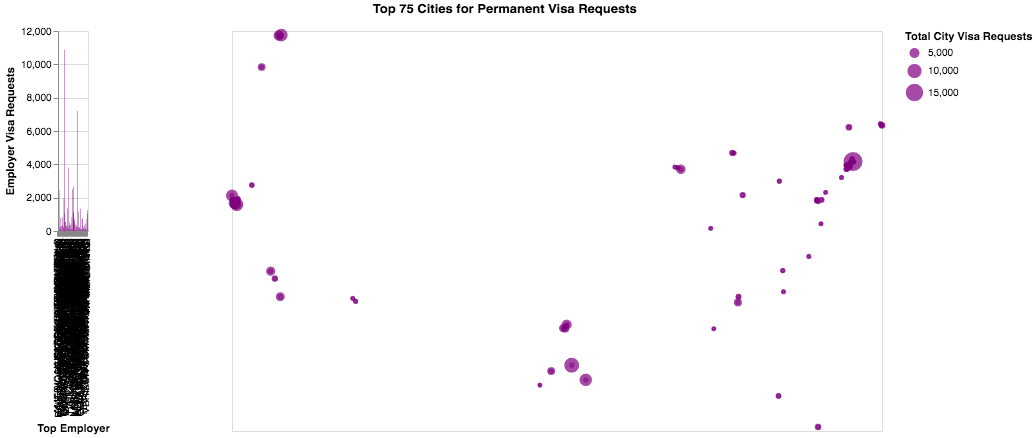

In [16]:
bars = alt.Chart(top75cities).mark_bar().encode(
    alt.X('top_employer',axis=alt.Axis(title='Top Employer')),
    alt.Y('employer_count',axis=alt.Axis(title='Employer Visa Requests'),scale=alt.Scale(domain=[0,12000])),
    alt.ColorValue('purple')
).transform_filter(
    hover.ref()
).properties(
    width=30,
    height=200
)

alt.hconcat(bars,chart,padding={'left':1, 'top': 1, 'right': 1, 'bottom': 1} )

A lot of conclusions can be drawn from this visualization: the top employers requesting permanent visas are on the West or East coasts, in Texas, or in the Midwest. Notably large employers are Cognizant Technology Solutions in College Station, Texas, which submits the most visa requests of any United States employer by a landslide, as well as Microsoft in Redmond, Washington, Apple in Cupertino, California, and Infosys in Plano, Texas. Additionally, the Brooklyn area has the most visa requests of any city, but does not have any individual employers with lots of requests (all are under 2,000), simply lots of employers overall.

### General Industry Visualization

Creates a visualization showing the top industries with approved visas, and the proportion of these approved employees that have a professional job, as classified by the visa application.

In [17]:
approved = visas[visas['case_status'] == 'Certified']

In [18]:
industvis = approved[['case_no','professional_occupation']].groupby(visas['naics_code']).aggregate('count').reset_index()

In [19]:
industvis['professional_occupation'] = (1 - industvis['professional_occupation'] / industvis['case_no'])

In [20]:
industvis['Name']=['Agriculture, Forestry, & Hunting', 'Mining', 'Utilities','Construction',
'Manufacturing','Wholesale Trade','Retail Trade','Transportation and Warehousing',
'Information','Finance & Insurance','Real Estate Rental & Leasing',
'Scientific & Technical Services','Management of Companies',
'Administrative & Remediation Services',
'Educational Services','Health Care & Social Assistance','Arts, Entertainment, & Recreation',
'Accommodation & Food Services','Other Services','Public Administration']

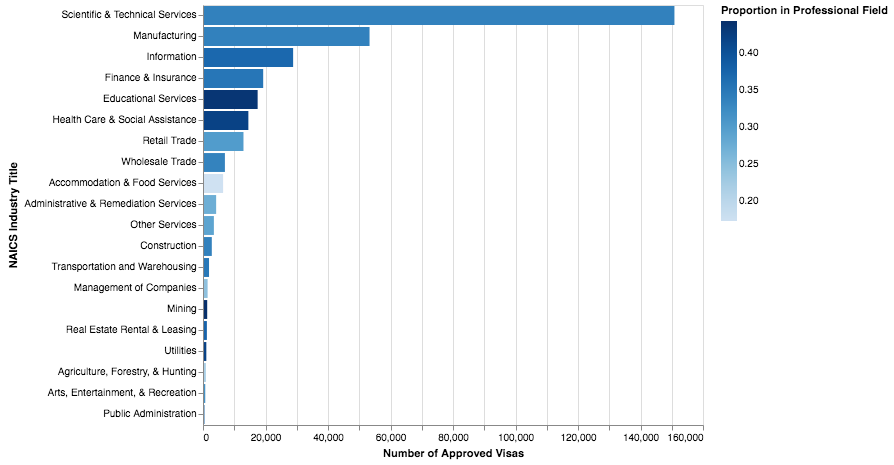

In [21]:
alt.Chart(industvis).mark_bar().encode(
    alt.X('case_no:Q',axis=alt.Axis(title="Number of Approved Visas")),
    alt.Y('Name:N',sort=alt.SortField(field='case_no',order='descending', op='sum'),
         axis=alt.Axis(title="NAICS Industry Title")),
    alt.Color('professional_occupation',legend=alt.Legend(title="Proportion in Professional Field"))
).properties(
    width=500
)

From this visualization, we can observe that the vast majority of approved visas are in the fields of Scientific and Technical Services, Manufacturing, and Information. Of these categories (as classified by the North American Industry Classification System), the most professional industries are Educational Services and Health care, and the least professional is Accomodation and Food Services. There are very few approved visas in the categories of Public Administration, Arts and Entertainment, and Agriculture.

### Birth Country Exploration

Explores the 10 birth countries with the highest rates of visa applications, and the proportion of each that are approved, with 2 different visualization options.

In [22]:
groups1 = visas['case_no'].groupby(visas['foreign_worker_info_birth_country']).aggregate('count').reset_index()
sorted1 = groups1.sort_values(by='case_no',ascending=False)
top10countriesr = sorted1.iloc[:10].copy()

In [23]:
groups2 = approved['case_no'].groupby(approved['foreign_worker_info_birth_country']).aggregate('count').reset_index()
sorted2 = groups2.sort_values(by='case_no',ascending=False)
top10countries = sorted2.iloc[:10].copy()

In [24]:
propslist = [x/y for x,y in zip(top10countries['case_no'],top10countriesr['case_no'])]
top10countries['props'] = propslist
top10countries['totals'] = top10countriesr['case_no']

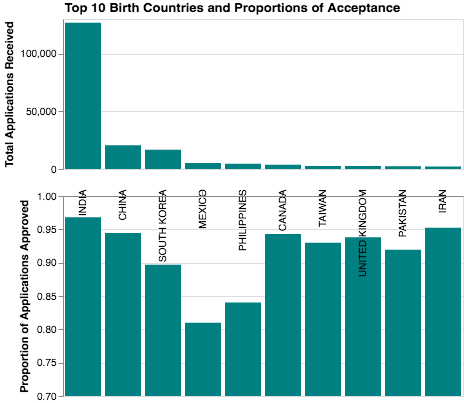

In [25]:
chart1 = alt.Chart(top10countries).mark_bar(color='teal').encode(
    alt.X('foreign_worker_info_birth_country:N',axis=alt.Axis(title=None,orient='top'),
          sort=alt.SortField(field='case_no',order='descending', op='sum')),
    alt.Y('props:Q',axis=alt.Axis(title="Proportion of Applications Approved"),
          sort=alt.SortField(field='props',order='descending', op='count'),
          scale=alt.Scale(domain=[0.7,1])),
).properties(
    height=200,
    width=400
)

chart2 = alt.Chart(top10countries).mark_bar(color='teal').encode(
    alt.X('foreign_worker_info_birth_country:N',axis=None,
          sort=alt.SortField(field='case_no',order='descending', op='sum')),
    alt.Y('totals:Q',axis=alt.Axis(title="Total Applications Received")),
).properties(
    title='Top 10 Birth Countries and Proportions of Acceptance',
    height=150,
    width=400
)

alt.vconcat(chart2,chart1,padding={'left':0, 'top': 0, 'right': 0, 'bottom': 0} )

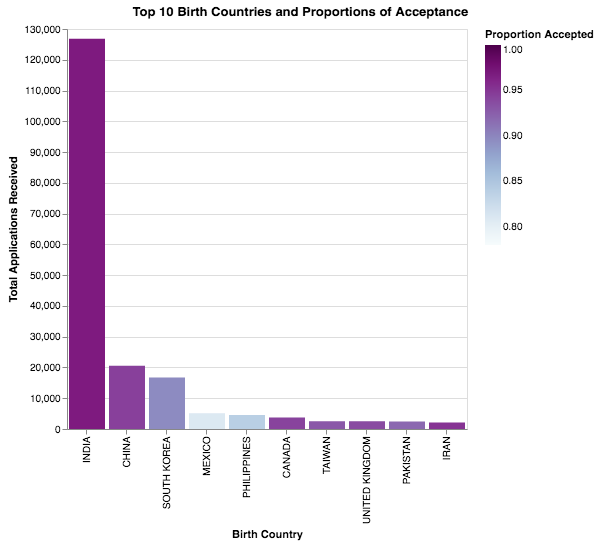

In [26]:
alt.Chart(top10countries).mark_bar().encode(
    alt.X('foreign_worker_info_birth_country:N',axis=alt.Axis(title='Birth Country'),
          sort=alt.SortField(field='case_no',order='descending', op='sum')),
    alt.Y('totals:Q',axis=alt.Axis(title="Total Applications Received")),
    alt.Color('props:Q',legend=alt.Legend(title='Proportion Accepted'),
             scale=alt.Scale(scheme='bluepurple',domain=[0.78,1]))
).properties(
    title='Top 10 Birth Countries and Proportions of Acceptance',
    height=400,
    width=400
)

Both of these visualizations demonstrate that by far, the largest number of applications and of approved visas are for immigrants from India. In addition, India also has one of the highest proportions of approved applications. Other common countries of origin include China, South Korea, and Mexico. Interestingly, Mexico has the lowest proportion of accepted visas, followed by the Philippines. This observation inspired the brief Mexico case study below.

#### Mexico Case Study

Since Mexico has a noticeably low approval rate, I take a more in-depth look at the composition of Mexican visa applications.

In [27]:
mexico = visas[visas['foreign_worker_info_birth_country']=='MEXICO']
mexico = mexico[pd.notnull(mexico['foreign_worker_info_education'])]
mexico = mexico[pd.notnull(mexico['pw_level_9089'])]
mexico = mexico[pd.notnull(mexico['professional_occupation'])]

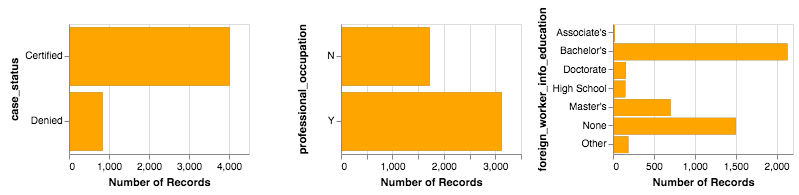

In [28]:
brush = alt.selection(type="single", encodings=['y'])

base = alt.Chart().mark_bar().encode(
    y=alt.Y(alt.repeat('column'),type='nominal'),
    x='count(*):Q'
).properties(
    width=180,
    height=130
)

background = base.properties(
    selection=brush
)

highlight = base.encode(
    alt.ColorValue('orange')
).transform_filter(
    brush.ref()
)

chart = alt.layer(
    background, highlight,
    data=mexico
).repeat(
    column=["case_status", "professional_occupation", "foreign_worker_info_education"],
)
chart

This interactive visualization allows the exploration of professional status and the highest level of education of Mexican visa applicants, as well as their relationships with whether the application was approved. Most notably, people with no education make up the majority of denied applications, while applicants with a degree, especially a Master's or Doctorate, consistently go into professional occupations, and are almost always approved. 

## Question 2: What factors are correlated with whether a visa request will be approved or denied?

### Relationship Between Decision Date and Approval

Here, I create a visualization of approval rates over time, from the end of 2011 to 2017.

In [29]:
groups1 = visas.groupby('decision_date')['case_status'].aggregate('count').reset_index()

In [30]:
groups2 = approved.groupby('decision_date')['case_status'].aggregate('count').reset_index()

In [31]:
decisiondates = groups1.merge(groups2, on='decision_date')

In [32]:
decisiondates['proportion'] = decisiondates['case_status_y'] / decisiondates['case_status_x']

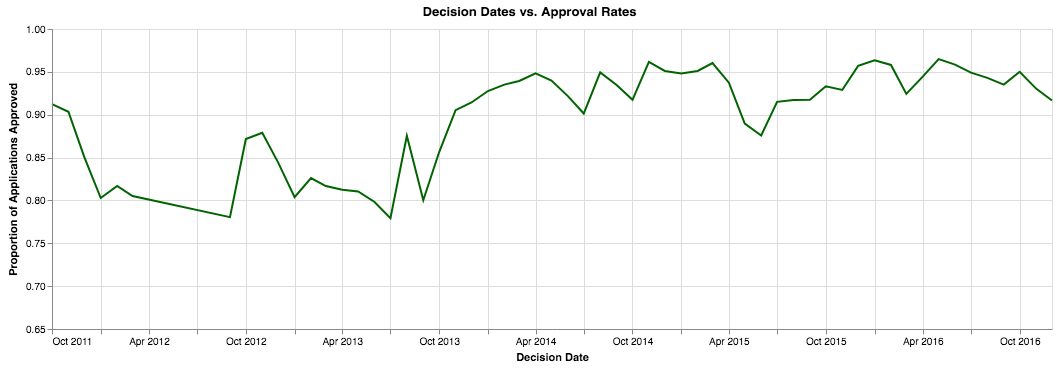

In [33]:
alt.Chart(decisiondates).mark_line(color='darkgreen').encode(
    alt.X('decision_date:T',axis=alt.Axis(title='Decision Date'),timeUnit='yearmonth'),
    alt.Y('mean(proportion):Q',axis=alt.Axis(title="Proportion of Applications Approved"),
          scale=alt.Scale(domain=[0.65,1])),
).properties(
    title='Decision Dates vs. Approval Rates',
    height=300,
    width=1000
)

There is definitely some relationship between date and approval; visa approval rates dipped down noticably in 2012 and 2013, and have been somewhat consistently higher since. 

### Top Employers and Proportions of Approval

This section explores the 15 employers that submit the most visa applications, and the proportions of these applications that get approved. I also look at, out of all employers that submitted over 500 applications, those with the lowest approval rates.

In [34]:
groups1 = visas.groupby('employer_name')['case_no'].aggregate('count').reset_index()
groups2 = approved.groupby('employer_name')['case_no'].aggregate('count').reset_index()

In [35]:
employersgrouped = groups1.merge(groups2, on='employer_name')

In [36]:
employersgrouped['props'] = employersgrouped['case_no_y'] / employersgrouped['case_no_x']

In [37]:
employerssorted = employersgrouped.sort_values(by='case_no_x',ascending=False)
topemployers = employerssorted[employerssorted['case_no_x']>=500]

In [38]:
top15employers = topemployers[:15]

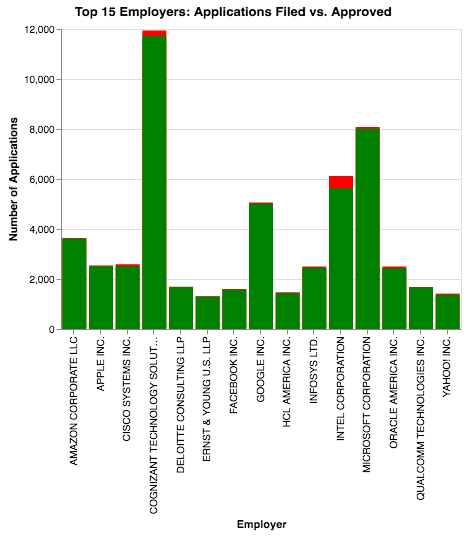

In [39]:
chart1 = alt.Chart(top15employers).mark_bar(color='red').encode(
    alt.X('employer_name:N',axis=alt.Axis(title='Employer')),
    alt.Y('case_no_x:Q',axis=alt.Axis(title="Number of Applications")),
).properties(
    height=300,
    width=400
)

chart2 = alt.Chart(top15employers).mark_bar(color='green').encode(
    alt.X('employer_name:N',
          sort=alt.SortField(field='case_no_x',order='descending', op='sum')),
    alt.Y('case_no_y:Q'),
).properties(
    title='Top 15 Employers: Applications Filed vs. Approved',
    height=300,
    width=400
)

chart1 + chart2

Most of the top employers have relatively high approval rates. Intel, however, has a noticably lower rate.

Although differences in employers with high approval rates were not interesting enough to warrant a visualization, I have included a list of the employers with approval rates over 99% and their exact rates.

In [40]:
employersx = topemployers.sort_values(by='props',ascending=True)
employerslow = employersx.iloc[:6].copy()
employersy = topemployers.sort_values(by='props',ascending=False)
employershigh = employersy.iloc[:15].copy()
employershigh[['employer_name','props']]

employer_name     props
25973     IGATE TECHNOLOGIES INC.  0.997003
14868     DELOITTE CONSULTING LLP  0.995856
2988         AMAZON CORPORATE LLC  0.995328
9528     CAPITAL ONE SERVICES LLC  0.994718
40000          NVIDIA CORPORATION  0.994406
44822  QUALCOMM TECHNOLOGIES INC.  0.993456
22431                 GOOGLE INC.  0.992292
42110                 PAYPAL INC.  0.991597
4161                   APPLE INC.  0.991325
32775        LINKEDIN CORPORATION  0.991111
14866       DELOITTE & TOUCHE LLP  0.991071
16751                   EBAY INC.  0.990762
36132       MICROSOFT CORPORATION  0.990720
43854      PRICEWATERHOUSECOOPERS  0.990318
18186      ERNST & YOUNG U.S. LLP  0.990091

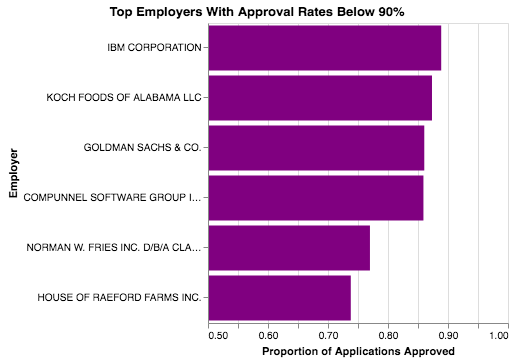

In [41]:
alt.Chart(employerslow).mark_bar(color='purple').encode(
    alt.X('props:Q',axis=alt.Axis(title="Proportion of Applications Approved"),
          scale=alt.Scale(domain=[0.5,1])),
    alt.Y('employer_name:N',axis=alt.Axis(title='Employer'),
          sort=alt.SortField(field='props',order='descending', op='sum')),
).properties(
    title='Top Employers With Approval Rates Below 90%',
    height=300,
    width=300
)

There are 6 top employers (that is, employers that submitted at least 500 visa applications) with approval rates below 90%. First, it is important to observe that none of them have dramatically low approval rates (all of them are still above 70%). However, it is worth noting that of the 6 employers with low approval rates, 3 are farming/food industry companies and two are technology-related.

### Visa Type Relationship With Approval

This section considers which visa types are most common, as well as how the type of visa relates to its approval:

In [42]:
visatype = visas.groupby('class_of_admission')['case_no'].aggregate('count').reset_index()

In [43]:
visatypea = visatype[visatype['case_no'] > 50]

In [44]:
visatypea = visatypea.sort_values(by='case_no',ascending=False)[:12]

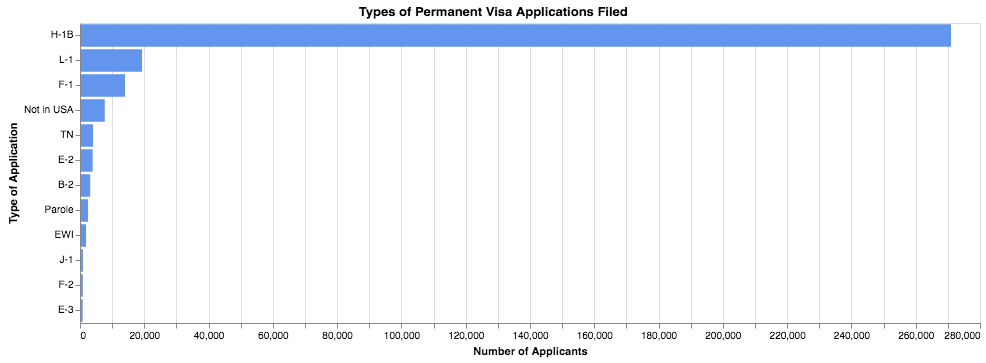

In [45]:
chart2 = alt.Chart(visatypea).mark_bar(color='cornflowerblue').encode(
    alt.Y('class_of_admission:N',axis=alt.Axis(title='Type of Application'),
          sort=alt.SortField(field='case_no',order='descending', op='sum')),
    alt.X('case_no:Q',axis=alt.Axis(title='Number of Applicants')),
).properties(
    title='Types of Permanent Visa Applications Filed',
    height=300,
    width=900
)
chart2

This visualization shows the vast majority of permanent visa applications are of class H1B, which is "Alien in a Specialty Occupation". Other common visas include the L-1 visa, "Intracompany Transferee", and F-1, "Student in an academic or language training program". For reference, EWI is "Entry Without Inspection", generally undocumented immigration.

In [46]:
visatype2 = approved.groupby('class_of_admission')['case_no'].aggregate('count').reset_index()
visasoverall = visatype.merge(visatype2, on='class_of_admission')
visasoverall['props'] = visasoverall['case_no_y'] / visasoverall['case_no_x']

In [47]:
visasoverall = visasoverall.sort_values(by='props',ascending=False)
visasoverallu = visasoverall[visasoverall['case_no_x']>50]

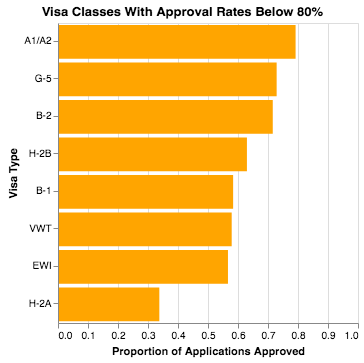

In [48]:
alt.Chart(visasoverallu[20:]).mark_bar(color='orange').encode(
    alt.X('props:Q',axis=alt.Axis(title="Proportion of Applications Approved"),
          scale=alt.Scale(domain=[0,1])),
    alt.Y('class_of_admission:N',axis=alt.Axis(title='Visa Type'),
          sort=alt.SortField(field='props',order='descending', op='sum')),
).properties(
    title='Visa Classes With Approval Rates Below 80%',
    height=300,
    width=300
)

It makes sense that these permanent work visas might be rejected, as many do not make sense for permanent employment in the U.S.:
- A1/A2 is Ambassador, Public Minister, Career Diplomat, Consular Officer, or other Foreign Government Official or Employee
- G-5 is Attendant, Servant, or Personal Employee of a Government Representative
- B-2 is Temporary Visitor for Pleasure
- H-2B is Temporary Worker Performing Non-Agricultural Services Unavailable in the United States
- B-1 is Temporary Visitor for Business
- VWT is a visa waiver for tourists
- EWI is Entry Without Inspection, generally undocumented Immigration
- H-2A is Temporary Worker Performing Agricultural Services Unavailable in the United States, with the lowest approval rate of any visa class - just over 30%.

### Education, Mean Salary, and Approval

In [49]:
edu = visas.groupby('job_info_education')['case_no'].aggregate('count').reset_index()

In [50]:
edu2 = approved.groupby('job_info_education')['case_no'].aggregate('count').reset_index()

In [51]:
edu = edu.merge(edu2, on='job_info_education')

In [52]:
edu['props'] = edu['case_no_y'] / edu['case_no_x']

In [53]:
wages = visas['annual_wage'].groupby(visas['job_info_education']).aggregate('mean').reset_index()

In [54]:
edu = edu.merge(wages,on='job_info_education')

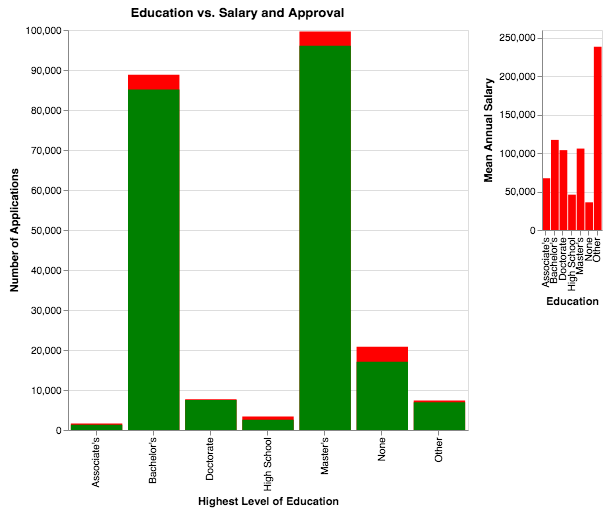

In [55]:
brush = alt.selection(type="single",encodings=['x'])


base = alt.Chart(edu).mark_bar(color='green').encode(
    alt.X('job_info_education:N',axis=alt.Axis(title='Highest Level of Education')),
    alt.Y('case_no_y:Q',axis=alt.Axis(title="Number of Applications")),
).properties(
    height=400,
    width=400
)

chart2 = base.mark_bar(color='red').encode(
    alt.X('job_info_education:N'),
    alt.Y('case_no_x:Q'),
).properties(
    title='Education vs. Salary and Approval',
    height=400,
    width=400
)

background = base.properties(
    selection=brush
)

chart1 = chart2 + background

bars = alt.Chart(edu).mark_bar().encode(
    alt.X('job_info_education',axis=alt.Axis(title='Education')),
    alt.Y('annual_wage',axis=alt.Axis(title='Mean Annual Salary'),scale=alt.Scale(domain=[0,250000])),
    alt.ColorValue('red')
).transform_filter(
    brush.ref()
).properties(
    width=60,
    height=200
)

alt.hconcat(chart1,bars)

In the context of this data set, "Other" as a highest level of education generally is an advanced medical degree, so it makes sense that they would have a high approval proportion, and a very high salary. Additionally, applicants with any degree (Bachelor's, Master's, or Doctorate) are likely to be approved. Having just a high school education, or no education at all, is associated with a much lower proportion of approval, and lower salaries.

Next: [Topic Modeling and Machine Learning](04-NLP & Modeling.ipynb)<br>